### **Load Environment variables from .env file**

In [7]:
from openai import AzureOpenAI
from dotenv import load_dotenv
import os
from IPython.display import display, HTML, JSON, Markdown, Image

load_dotenv()
GPT4o_API_KEY = os.getenv("GPT4o_API_KEY")
GPT4o_DEPLOYMENT_ENDPOINT = os.getenv("GPT4o_DEPLOYMENT_ENDPOINT")
GPT4o_DEPLOYMENT_NAME = os.getenv("GPT4o_DEPLOYMENT_NAME")


client = AzureOpenAI(
  azure_endpoint = GPT4o_DEPLOYMENT_ENDPOINT, 
  api_key=GPT4o_API_KEY,  
  api_version="2024-02-01"
)

In [8]:
def call_gpt4o_with_imgs(image_list):
    text=[
    {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video using the frames from the video provided."},
    {"role": "user", "content": [
        *map(lambda x: {"type": "image_url", 
                        "image_url": {
                            "url": f'data:image/jpg;base64,{x}', 
                            "detail": "low"}}, image_list)
        ],
    }
    ]
    response = client.chat.completions.create(
        model=GPT4o_DEPLOYMENT_NAME,
        messages = text,
        temperature=0.0
    )
    return response.choices[0].message.content

def call_gpt4o(transcript):
    text=[
        {"role": "system", "content": "You are generating a video summary. Please provide a summary of the video transcript."},
        {"role": "user", "content": transcript}
    ]
    response = client.chat.completions.create(
        model=GPT4o_DEPLOYMENT_NAME,
        messages = text,
        temperature=0.0
    )
    return response.choices[0].message.content

In [9]:
import cv2
from moviepy.editor import VideoFileClip
import time
import base64

# We'll be using the OpenAI DevDay Keynote Recap video. You can review the video here: https://www.youtube.com/watch?v=h02ti0Bl6zk
VIDEO_PATH = "data/keynote_recap.mp4"

In [10]:
import os
def process_video(video_path, seconds_per_frame=2):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    # Extract audio from video
    audio_path = f"{base_video_path}.mp3"
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, bitrate="32k")

    print(f"Extracted {len(base64Frames)} frames")
    print(f"Extracted audio to {audio_path}")
    return base64Frames, audio_path

# Extract 1 frame per second. You can adjust the `seconds_per_frame` parameter to change the sampling rate
base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=1)

MoviePy - Writing audio in data/keynote_recap.mp3


MoviePy - Done.
Extracted 218 frames
Extracted audio to data/keynote_recap.mp3


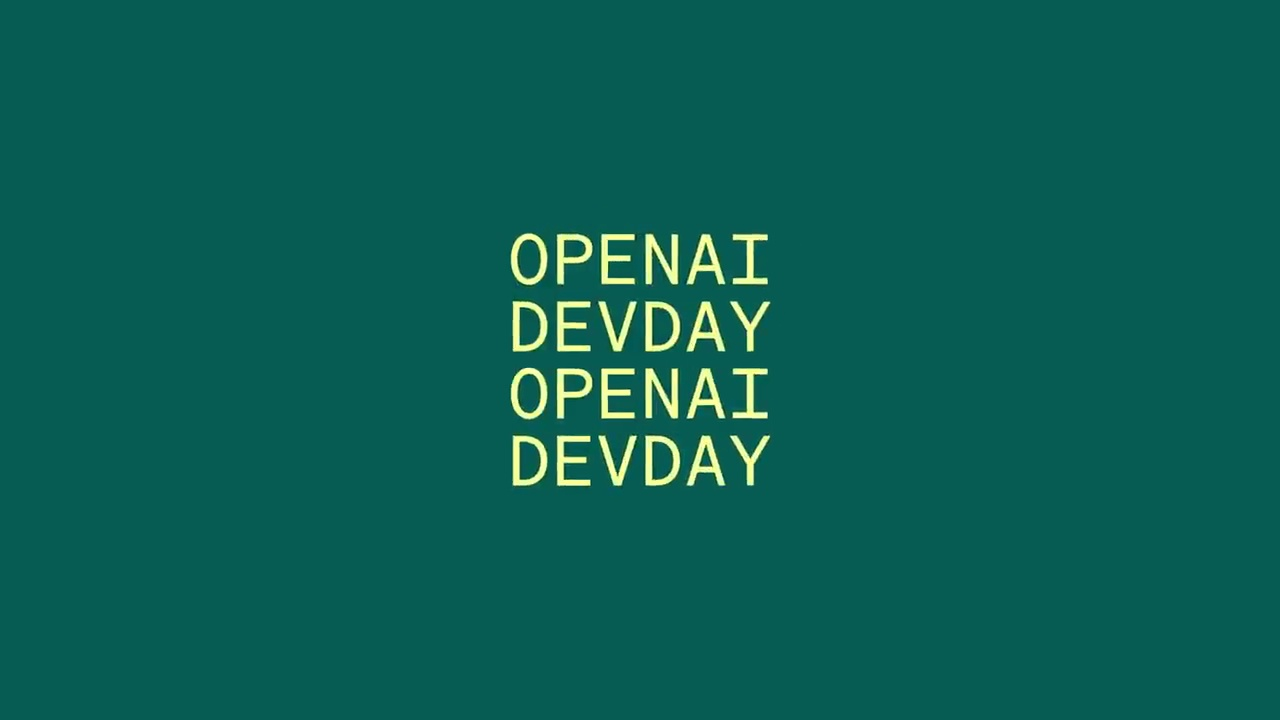

In [11]:

## Display the frames and audio for context
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.025)

In [12]:
# print the number of frames
print(f"Total frames: {len(base64Frames)}")

Total frames: 218


### Example 1: Summarization
The visual summary is generated by sending the model only the frames from the video. With just the frames, the model is likely to capture the visual aspects, but will miss any details discussed by the speaker.

In [13]:
# grab 20 frames and send them to GPT-4o for summarization
# create a loop to grab every 20 frames and send them to OpenAI for summarization from base64Frames
import copy 

nr_of_pics = len(base64Frames)
nr_of_pics_per_round = 20
start = 0
end = nr_of_pics_per_round-1
messages = []
runs = 1
accumulated_result = ""
while end < nr_of_pics:
    partial_frames = copy.deepcopy(base64Frames[start:end])
    result = call_gpt4o_with_imgs(partial_frames)
    print(f"Run {runs} - {start} to {end}")
    display(result)
    accumulated_result += result
    if nr_of_pics - end < nr_of_pics_per_round:
        break
    start = end+1
    end = start + nr_of_pics_per_round-1
    runs += 1
partial_frames = copy.deepcopy(base64Frames[end+1:nr_of_pics-1])
result = call_gpt4o_with_imgs(partial_frames)
accumulated_result += result

Run 1 - 0 to 19


'The video appears to be a summary of the OpenAI DevDay event. It begins with a title screen displaying "OPENAI DEVDAY" and transitions to a "Keynote Recap" segment. The video then shows the exterior of the event venue with an OpenAI DevDay sign, followed by the OpenAI logo.\n\nInside the venue, there are scenes of attendees moving around and the main stage area filling up with people. The event seems well-attended, with a large audience seated and ready for the keynote presentation.\n\nThe keynote speaker is shown on stage, delivering a presentation with the "OPENAI DEVDAY" backdrop. The audience is engaged, with some members clapping. The video concludes with another title screen reiterating "OPENAI DEVDAY."'

Run 2 - 20 to 39


'The video appears to be a presentation or keynote event. Here is a summary based on the provided frames:\n\n1. The video begins with an animation of a logo on a light pink background.\n2. The scene transitions to a stage where a speaker is presenting.\n3. The speaker introduces "GPT-4" and then "GPT-4 Turbo," as indicated by the text on the screen behind them.\n4. The speaker continues to discuss "GPT-4 Turbo," with the text remaining on the screen for several frames.\n5. The speaker is shown in close-up shots, holding a clicker and speaking to the audience.\n6. The presentation then shifts to a demonstration of a feature called "JSON Mode: ON," with an example JSON snippet displayed on the screen.\n\nThe video likely covers the introduction and features of GPT-4 Turbo, including a demonstration of its capabilities with JSON data.'

Run 3 - 40 to 59


'The video appears to be a presentation or keynote, likely related to a tech or software development topic. Here is a summary based on the provided frames:\n\n1. **Introduction to JSON Mode**: The video starts with a slide showing a JSON object with weather information and a toggle switch indicating "JSON Mode: ON."\n\n2. **Function Calling**: The next slide demonstrates an improvement in function calling. The "Before" section shows a command to raise windows and turn on the radio, which is split into two separate functions in the "After" section for better clarity and control.\n\n3. **Presenter**: A person is seen explaining the function calling improvement, emphasizing the separation of commands for better functionality.\n\n4. **Key Features**: The presenter stands in front of a slide listing six key features or improvements:\n   - Context length\n   - More control\n   - Better knowledge\n   - (The remaining three features are not visible in the provided frames)\n\n5. **Further Expla

Run 4 - 60 to 79


'The video appears to be a presentation or keynote event held in April 2023. The speaker, whose face is blurred, is discussing several technological advancements and new features. The key points highlighted in the presentation include:\n\n1. **DALL-E 3**: A new version of the DALL-E model, which is likely related to image generation or manipulation.\n2. **GPT-4**: The latest version of the GPT model, featuring "Turbo" and "Vision" capabilities, suggesting enhancements in speed and visual processing.\n3. **TTS**: This could refer to Text-to-Speech technology, indicating advancements in converting text into spoken words.\n4. **Custom Models**: The speaker also mentions the availability of custom models, which could imply tailored AI models for specific applications or industries.\n\nThe presentation seems to focus on the latest developments in AI and machine learning technologies, showcasing improvements and new features in these areas.'

Run 5 - 80 to 99


'The video appears to be a presentation or keynote speech. The speaker, dressed in a green sweater and dark pants, is addressing an audience on stage. The background is mostly dark, with a large screen displaying various slides.\n\nKey points from the video include:\n\n1. The speaker discusses a topic related to "2x tokens per minute," which is displayed prominently on the screen behind him.\n2. The presentation includes a demonstration or explanation of a feature related to "Request a limit increase" for a model named "gpt-3.5-turbo." The interface shown allows users to request an increase in the rate limit, specifying the limit type, model, and requested rate limit.\n3. The speaker appears to be explaining the process and benefits of this feature, emphasizing the ability to handle higher limits.\n\nThe video seems to focus on technical aspects and improvements related to a specific model or service, likely aimed at an audience interested in technology or software development.'

Run 6 - 100 to 119


'The video appears to be a presentation, likely from an event hosted by OpenAI, given the branding and content. Here is a summary based on the provided frames:\n\n1. **Introduction to GPT-4 Turbo Pricing**: The presenter introduces the topic of GPT-4 Turbo pricing.\n2. **Efficiency Improvements**: The presentation highlights that GPT-4 Turbo uses 3 times fewer input tokens and 2 times fewer output tokens, indicating significant efficiency improvements.\n3. **OpenAI Dev Day Branding**: The video includes branding for "OpenAI Dev Day," suggesting this is an event or conference organized by OpenAI.\n4. **OpenAI Logo Animation**: There is an animation of the OpenAI logo, reinforcing the brand identity.\n5. **Showcase of Various Applications**: The video showcases a variety of applications or tools, possibly developed using OpenAI\'s technology, displayed in a grid format.\n6. **Introduction to GPTs**: The term "GPTs" is displayed, likely referring to different versions or applications of t

Run 7 - 120 to 139


'The video appears to be a presentation or keynote speech. The speaker, dressed in a green sweater and dark pants, is addressing an audience on a stage. The background is dark, and the speaker uses slides to emphasize key points. \n\n1. The initial frames show the speaker introducing the topic.\n2. The slides behind the speaker display three main points: "Instructions," "Expanded knowledge," and "Actions."\n3. The speaker elaborates on these points, gesturing to emphasize the content.\n4. The final frames highlight a key message: "Build with natural language," suggesting the presentation is about natural language processing or a related technology.\n5. The video concludes with a logo or branding slide.\n\nThe presentation seems to focus on the importance of natural language in building technology, possibly discussing advancements or applications in this field.'

Run 8 - 140 to 159


'The video appears to be a presentation or keynote event. The speaker, whose face is blurred, is presenting on stage in front of an audience. The presentation includes a slide with three icons: a person, a globe, and a grid of squares, possibly representing different aspects of a product or service.\n\nThe speaker then transitions to a slide showing a menu with categories such as Programming, Data Analysis, Education, Lifestyle, and Just for Fun. This suggests the presentation is about a platform or application that offers various functionalities or services in these areas.\n\nFollowing this, the video shows a screen with "Featured GPTs" and "GPTs powered by DALL-E," indicating a focus on AI technologies, specifically GPT (Generative Pre-trained Transformer) models and DALL-E, an AI model for generating images from text descriptions.\n\nThe final frames show a 3D cube with the word "PEOPLE" on its sides, which then zooms out to a small square, possibly symbolizing a focus on people or 

Run 9 - 160 to 179


'The video appears to be a presentation at an event called "OpenAI DevDay." The speaker, whose face is blurred, is discussing various technical topics related to APIs. The presentation includes slides that highlight key concepts such as "Threading," "Retrieval," "Code Interpreter," and "Function Calling." The event seems to be focused on developers and technical audiences, providing insights into OpenAI\'s tools and capabilities. The video concludes with a slide reiterating the event\'s name, "OpenAI DevDay."'

Run 10 - 180 to 199


'The video appears to be from an event called "OpenAI DevDay." The speaker, whose face is blurred, is on stage delivering a presentation. The background prominently features the words "OPENAI" and "DEVDAY" repeatedly. The speaker is dressed casually in a green sweater, dark pants, and colorful sneakers. The presentation seems to be focused on topics related to OpenAI, likely discussing new developments, technologies, or updates relevant to developers. The speaker uses hand gestures to emphasize points during the talk.'

In [14]:
final = call_gpt4o(accumulated_result)
display(final)

'The video is a summary of the OpenAI DevDay event, capturing key moments and highlights from the presentation. It begins with a title screen displaying "OPENAI DEVDAY" and transitions to scenes of the event venue, showcasing the OpenAI logo and the bustling atmosphere as attendees gather for the keynote.\n\nThe keynote speaker is shown on stage, introducing significant advancements and new features in OpenAI\'s technology. Key points discussed include:\n\n1. **GPT-4 and GPT-4 Turbo**: The speaker introduces these new versions, emphasizing their enhanced capabilities.\n2. **JSON Mode**: A demonstration of a feature called "JSON Mode: ON" is shown, highlighting its practical applications.\n3. **Function Calling Improvements**: The presentation covers improvements in function calling, showcasing a before-and-after comparison for better clarity and control.\n4. **Key Features**: The speaker lists several key features, including increased context length, more control, and better knowledge.